In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


 ### 讀入資料

In [7]:
ori_data = pd.read_csv('HW4_creditcard.csv')

 ### 切割資料

In [8]:
train_data,test_data,train_target,test_target = train_test_split(np.array(ori_data[ori_data.columns[:-1]]),np.array(ori_data[ori_data.columns[-1]]),test_size=0.3)

### 訓練

In [9]:
tree = DecisionTreeClassifier()
tree.fit(train_data,train_target)
tree_pred = tree.predict(test_data)

mpl = MLPClassifier()
mpl.fit(train_data, train_target)
mpl_pred = mpl.predict(test_data)


### 評分

tree Accuracy : 0.99,  Recall:0.84211, Precision : 0.81, F1_score : 0.82657
mlp Accuracy : 0.90,  Recall:0.13174, Precision : 0.92, F1_score : 0.23049


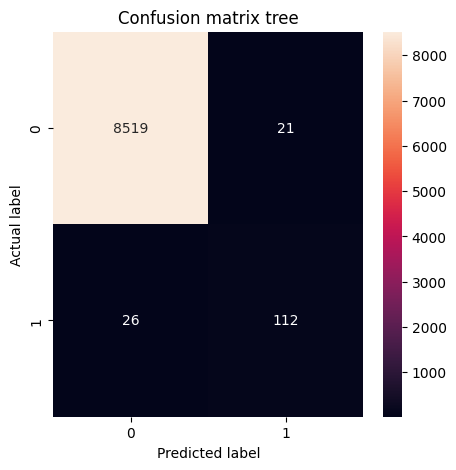

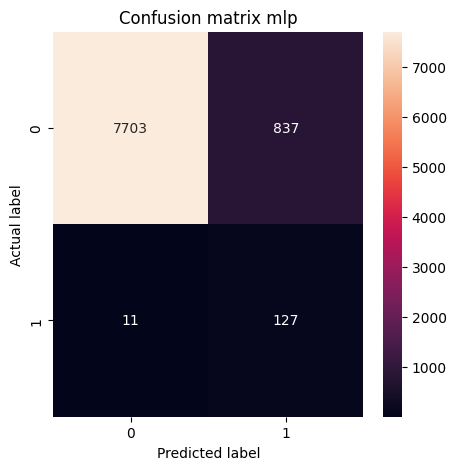

In [10]:
def score_method(target,pred,model):
    tn = len(test_target[(test_target == pred) & (test_target == 0)])
    tp = len(test_target[(test_target == pred) & (test_target == 1)])
    fn = len(test_target[(test_target != pred) & (test_target == 0)])
    fp = len(test_target[(test_target != pred) & (test_target == 1)])
    
    accuracy = (tp+fn)/(tp+fp+tn+fn)
    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    F1_score = (2/(( 1/precision) + ( 1/recall)))


    cm = confusion_matrix(target, pred > 0.5)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(f'Confusion matrix {model}')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
    print(   f'{model} Accuracy : {score:.2f},  Recall:{recall:.5f}, Precision : {precision:.2f}, F1_score : {F1_score:.5f}')


score = tree.score(test_data, test_target)
score_method(test_target,tree_pred,'tree')



score = mpl.score(test_data, test_target)
score_method(test_target,mpl_pred,'mlp')





### 統計0、1數量

0: 28432,1 : 492


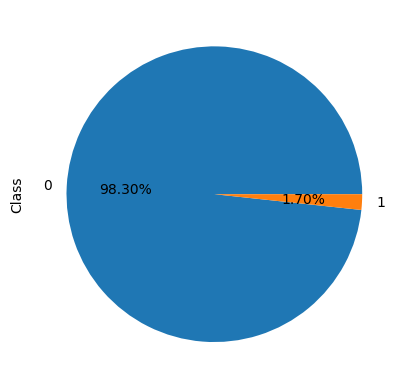

In [11]:


true_num = len(ori_data[ori_data['Class'] == 0])
false_num = len(ori_data[ori_data['Class'] == 1])

ori_data['Class'].value_counts().plot(kind='pie', autopct='%1.2f%%')
print(f'0: {true_num},1 : {false_num}')


### 改變類別權重

 - 決策樹

Weight for class 0: 0.51
Weight for class 1: 28.60
tree Accuracy : 0.90,  Recall:0.84211, Precision : 0.81, F1_score : 0.82657
cw-tree Accuracy : 0.90,  Recall:0.71338, Precision : 0.81, F1_score : 0.75932


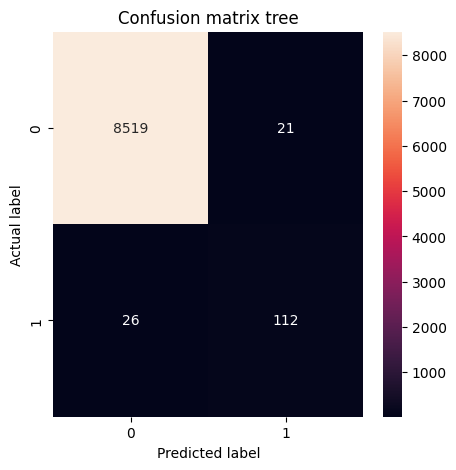

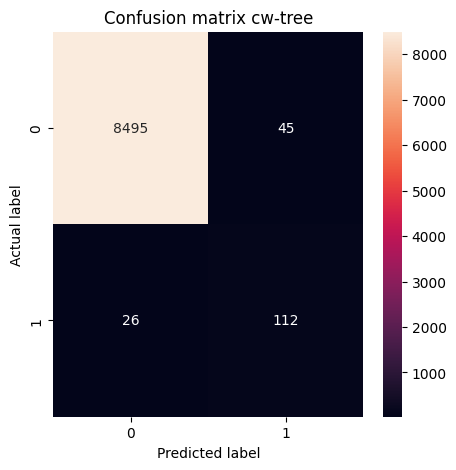

In [12]:
total = len(train_target)
pos = len(train_target[train_target == 1])
neg = len(train_target[train_target == 0])

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f'Weight for class 0: {weight_for_0:.2f}')
print(f'Weight for class 1: {weight_for_1:.2f}')

cw_tree = DecisionTreeClassifier(class_weight=class_weight)
cw_tree.fit(train_data, train_target)
cw_tree_pred = cw_tree.predict(test_data)

score_method(test_target,tree_pred,'tree')
score_method(test_target,cw_tree_pred,'cw-tree')



些許提升 recall 、f1-score 值

 - 神經網絡

In [13]:
import tensorflow as tf
from tensorflow import keras

將test_data 切割

In [217]:
train_data =train_data
train_target =train_target

val_data = test_data[:int(len(test_data)*0.5)]
val_target = test_target[:int(len(test_data)*0.5)]

test_data_cnn = test_data[int(len(test_data)*0.5):]
test_target_cnn = test_target[int(len(test_data)*0.5):]


選擇要記錄之資料

In [292]:
METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='roc', curve='roc'),
    keras.metrics.AUC(name='prc', curve='PR')
]


建立模型

In [293]:
def make_model(metrics=METRICS):
    model = keras.Sequential()
    
    model.add(keras.layers.Dense(100,activation='relu',input_shape=(train_data.shape[-1],)))
    model.add(keras.layers.Dropout(0.2))
    
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)
    
    return model


設定early stopping。以prc曲線作為monitor(由於此對不平衡數據特別敏感)

In [294]:
EPOCHS = 100
BATCH_SIZE = 1024

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc',
    verbose=1,
    patience= 20,
    mode='max',
    restore_best_weights=True
)

model = make_model()
model.summary()


Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_160 (Dense)           (None, 100)               3100      
                                                                 
 dropout_89 (Dropout)        (None, 100)               0         
                                                                 
 dense_161 (Dense)           (None, 1)                 101       
                                                                 
Total params: 3,201
Trainable params: 3,201
Non-trainable params: 0
_________________________________________________________________


訓練

In [295]:
baseline_history = model.fit(
    train_data,
    train_target[:,np.newaxis],
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_data, val_target))

Epoch 1/100
20/20 [==============================] - 4s 55ms/step - loss: 1829.3091 - tp: 103.0000 - fp: 6427.0000 - tn: 13465.0000 - fn: 251.0000 - accuracy: 0.6702 - precision: 0.0158 - recall: 0.2910 - auc: 0.4843 - roc: 0.4843 - prc: 0.0166 - val_loss: 143.5695 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 4270.0000 - val_fn: 69.0000 - val_accuracy: 0.9841 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_roc: 0.5000 - val_prc: 0.0159
Epoch 2/100
20/20 [==============================] - 0s 7ms/step - loss: 270.9416 - tp: 6.0000 - fp: 348.0000 - tn: 19544.0000 - fn: 348.0000 - accuracy: 0.9656 - precision: 0.0169 - recall: 0.0169 - auc: 0.4996 - roc: 0.4996 - prc: 0.0174 - val_loss: 199.9408 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 4270.0000 - val_fn: 69.0000 - val_accuracy: 0.9841 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_roc: 0.5000 - val_prc: 0.0159
Epoch 3/100
20/20 [==============================] - 

In [296]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_", " ").capitalize()
    plt.subplot(2, 2, n+1)
    plt.plot(history.epoch,
             history.history[metric], color='r', label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color='b', linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)

    plt.legend()


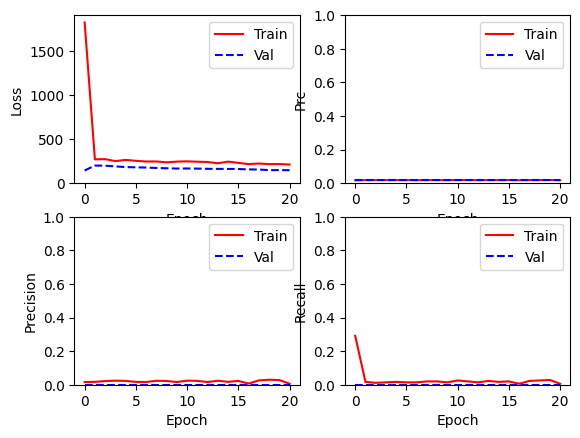

In [297]:
plot_metrics(baseline_history)


測試

In [298]:
test_predictions_baseline = model.predict(test_data_cnn, batch_size=BATCH_SIZE)


In [299]:
def plot_cm(labels, predictions, model):
  cm = confusion_matrix(labels, predictions > 0.5)
  plt.figure(figsize=(5, 5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title(f'Confusion matrix {model}')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')


In [300]:
def print_metrix(metrics_names, results):
    for name, value in zip(metrics_names, results):
        print(name, ': ', value)


loss :  181.83892822265625
tp :  0.0
fp :  0.0
tn :  4270.0
fn :  69.0
accuracy :  0.9840977191925049
precision :  0.0
recall :  0.0
auc :  0.5
roc :  0.5
prc :  0.015902280807495117


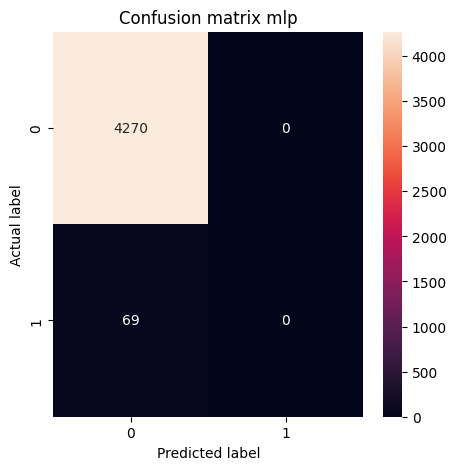

In [301]:
baseline_results = model.evaluate(test_data_cnn, test_target_cnn[:,np.newaxis],
                                  batch_size=BATCH_SIZE, verbose=0)

print_metrix(model.metrics_names,baseline_results)
plot_cm(test_target_cnn[:, np.newaxis], test_predictions_baseline,'mlp')


In [302]:
total = len(train_target)
pos = len(train_target[train_target == 1])
neg = len(train_target[train_target == 0])

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f'Weight for class 0: {weight_for_0:.2f}')
print(f'Weight for class 1: {weight_for_1:.2f}')


Weight for class 0: 0.51
Weight for class 1: 28.60


加入class_weight

In [303]:
weighted_model = make_model()

weighted_history = weighted_model.fit(
    train_data,
    train_target,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_data, val_target),
    class_weight=class_weight)


Epoch 1/100
20/20 [==============================] - 3s 56ms/step - loss: 2170.8320 - tp: 132.0000 - fp: 7081.0000 - tn: 17081.0000 - fn: 291.0000 - accuracy: 0.7001 - precision: 0.0183 - recall: 0.3121 - auc: 0.5096 - roc: 0.5096 - prc: 0.0177 - val_loss: 1537.6711 - val_tp: 69.0000 - val_fp: 4270.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0159 - val_precision: 0.0159 - val_recall: 1.0000 - val_auc: 0.5002 - val_roc: 0.5002 - val_prc: 0.0159
Epoch 2/100
20/20 [==============================] - 0s 8ms/step - loss: 1606.5338 - tp: 156.0000 - fp: 9337.0000 - tn: 10555.0000 - fn: 198.0000 - accuracy: 0.5290 - precision: 0.0164 - recall: 0.4407 - auc: 0.4848 - roc: 0.4848 - prc: 0.0168 - val_loss: 3.4911 - val_tp: 2.0000 - val_fp: 19.0000 - val_tn: 4251.0000 - val_fn: 67.0000 - val_accuracy: 0.9802 - val_precision: 0.0952 - val_recall: 0.0290 - val_auc: 0.5087 - val_roc: 0.5087 - val_prc: 0.0216
Epoch 3/100
20/20 [==============================] - 0s 7ms/step - loss: 

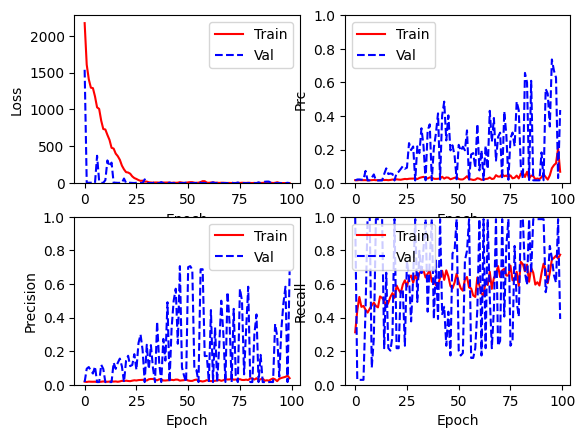

In [304]:
plot_metrics(weighted_history)

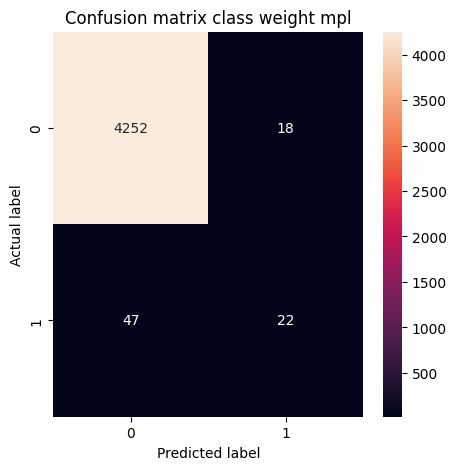

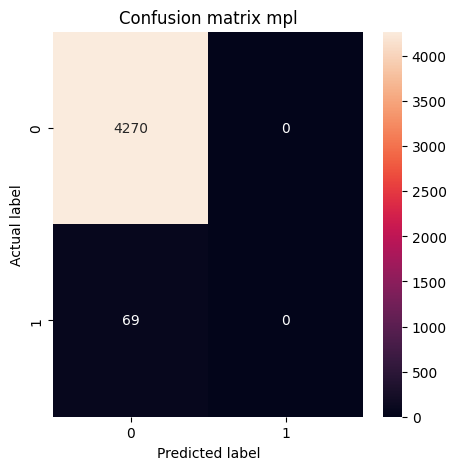

In [305]:
weighted_baseline_results = weighted_model.evaluate(test_data_cnn, test_target_cnn[:, np.newaxis],
                                  batch_size=BATCH_SIZE, verbose=0)



test_predictions_weighted_baseline = weighted_model.predict(
    test_data_cnn, batch_size=BATCH_SIZE)


plot_cm(test_target_cnn[:, np.newaxis], test_predictions_weighted_baseline,'class weight mpl')
plot_cm(test_target_cnn[:, np.newaxis], test_predictions_baseline,'mpl')

In [288]:
print_metrix(weighted_model.metrics_names,weighted_baseline_results)
print()
print_metrix(model.metrics_names,baseline_results)

loss :  0.19953085482120514
tp :  27.0
fp :  22.0
tn :  4248.0
fn :  42.0
accuracy :  0.9852500557899475
precision :  0.5510203838348389
recall :  0.3913043439388275
auc :  0.7290619611740112
prc :  0.3683508336544037

loss :  158.22984313964844
tp :  0.0
fp :  0.0
tn :  4270.0
fn :  69.0
accuracy :  0.9840977191925049
precision :  0.0
recall :  0.0
auc :  0.5
prc :  0.015902280807495117


由於sklearn 的mplclassifier無法加入class weight，故以keras建立神經網絡，發現加入classweight後，結果大幅提升

#### 使用smote 增量

In [289]:
from imblearn.over_sampling import SMOTE

In [290]:
smote_train_data,smote_train_target = SMOTE().fit_resample(train_data,train_target)

 - 決策樹

tree Accuracy : 0.99,  Recall:0.79592, Precision : 0.81, F1_score : 0.80137
smote_tree Accuracy : 0.99,  Recall:0.58036, Precision : 0.90, F1_score : 0.70461


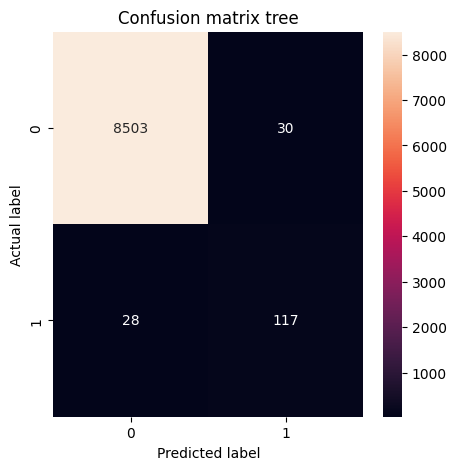

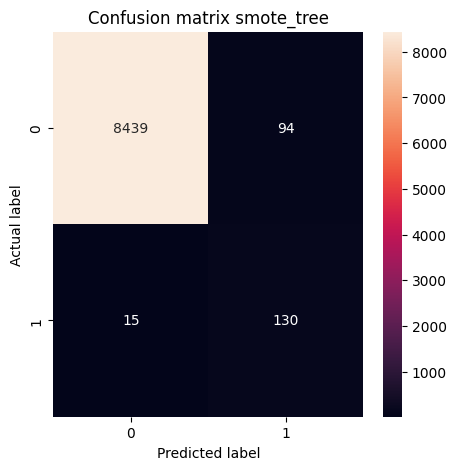

In [ ]:

smote_tree = DecisionTreeClassifier()
smote_tree.fit(smote_train_data,smote_train_target)
smote_tree_pred = smote_tree.predict(test_data)



score_method(test_target,tree_pred,'tree')
score_method(test_target,smote_tree_pred,'smote_tree')

以smote oversampling 後，效果顯著提升，然而加入class weight 後，效果下降

 - 神經網絡

In [343]:
smote_early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc',
    verbose=1,
    patience=20,
    mode='max',
    restore_best_weights=True
)
SMOTE_EPOCHS = 1000 

In [344]:
smote_model = make_model()
smote_baseline_history = smote_model.fit(
    smote_train_data,
    smote_train_target[:, np.newaxis],
    batch_size=BATCH_SIZE,
    epochs=SMOTE_EPOCHS,
    callbacks=[smote_early_stopping],
    validation_data=(val_data, val_target))



Epoch 1/1000
39/39 [==============================] - 3s 34ms/step - loss: 2278.3413 - tp: 9075.0000 - fp: 9456.0000 - tn: 14706.0000 - fn: 10886.0000 - accuracy: 0.5390 - precision: 0.4897 - recall: 0.4546 - auc: 0.4930 - roc: 0.4930 - prc: 0.4642 - val_loss: 12.7197 - val_tp: 1.0000 - val_fp: 5.0000 - val_tn: 4265.0000 - val_fn: 68.0000 - val_accuracy: 0.9832 - val_precision: 0.1667 - val_recall: 0.0145 - val_auc: 0.5057 - val_roc: 0.5057 - val_prc: 0.0189
Epoch 2/1000
39/39 [==============================] - 0s 6ms/step - loss: 1713.3967 - tp: 9282.0000 - fp: 9170.0000 - tn: 10722.0000 - fn: 10610.0000 - accuracy: 0.5028 - precision: 0.5030 - recall: 0.4666 - auc: 0.5027 - roc: 0.5027 - prc: 0.5020 - val_loss: 4.2732 - val_tp: 13.0000 - val_fp: 96.0000 - val_tn: 4174.0000 - val_fn: 56.0000 - val_accuracy: 0.9650 - val_precision: 0.1193 - val_recall: 0.1884 - val_auc: 0.5804 - val_roc: 0.5804 - val_prc: 0.0412
Epoch 3/1000
39/39 [==============================] - 0s 5ms/step - loss: 

In [353]:
def smote_plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_", " ").capitalize()
    plt.subplot(2, 2, n+1)
    plt.plot(history.epoch,
             history.history[metric], color='r', label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color='b', linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    
    plt.legend()


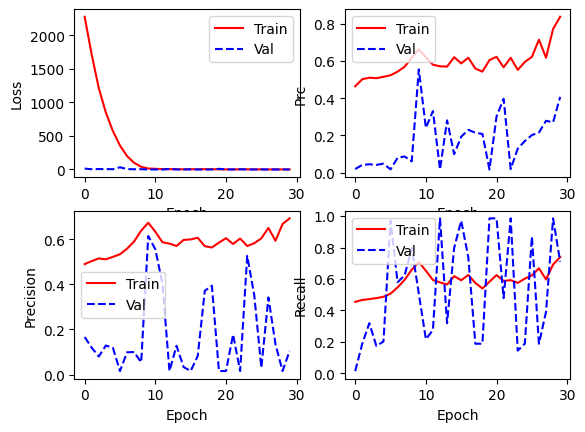

In [354]:
smote_plot_metrics(smote_baseline_history)

In [351]:
smote_test_predictions_baseline = smote_model.predict(test_data_cnn, batch_size=BATCH_SIZE)
smote_baseline_results = smote_model.evaluate(test_data_cnn, test_target_cnn[:, np.newaxis],
                                  batch_size=BATCH_SIZE, verbose=0)

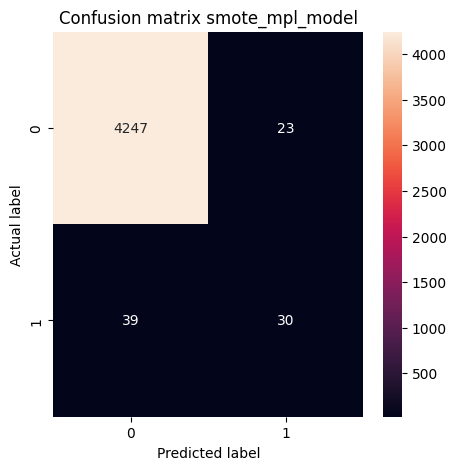

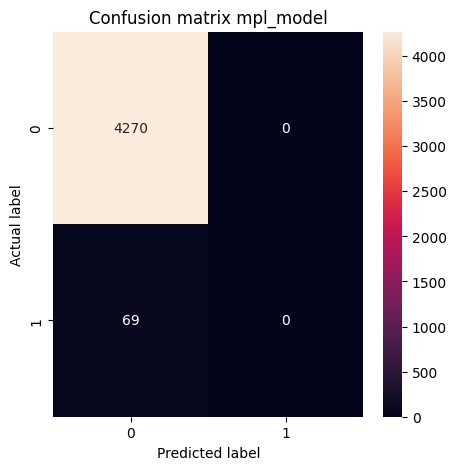

In [352]:
plot_cm(test_target_cnn[:, np.newaxis], smote_test_predictions_baseline,'smote_mpl_model')
plot_cm(test_target_cnn[:, np.newaxis], test_predictions_baseline,'mpl_model')
